# LAB 1


    The RR Lyrae are one of the most important classes of radial pulsating variable star in astronomy. It is probable that our understanding of both the size and 
    nature of our Universe would be far more incomplete in absence of these stars. Today, the easy to recognize pulsating variables are used as primary standard 
    candles to measure extragalactic distances. They live alongside the 
    elite class of pulsating variables known as instability strip pulsators, 
    where the horizontal branch aging stars of spectral class A to F have 
    a mass of around half of the Suns. As well, their period of pulsation 
    and absolute magnitude makes them especially suitable for measurements within 
    the Milky Way. 

This article presents a simple analysis of some of the most important aspects of the RR Lyrae class. In the first section RR Lyrae data is gathered from the Gaia variability catalogs, and a Lomb Scargle method is applied to estimate the periodicity of the pulsating stars. This simplistic approach is then compared to the estimates provided by the Gaia catalog itself. It is found a coincidence of 62 percent, based on a naive box cut comparison. The second part of the article evaluates the galactic distances associated with the RR Lyraes and introduces the effects of dust in the data. A prior is placed from the Bailer Jones estimates located in the Gaia external catalogs, and it is then compared to the estimates made after several restricting cuts on the Gaia set. It is found that the deviation between the estimates increases along side increasing distance. In the end a final selection of 395 stars are made, reduced from the original amount of 468. 

The third part of this article is centered around fitting a line to the selection of stars made in part 2. This fitting assumes a logarithmic model, and exploits an Bayesian approach to model fitting. An Monte Carlo Markov Chain (McMc) is applied to evaluate parameter estimations. In an first instance this method is applied to the RR Lyrae data on the selection of the 395 stars. In the second line fit the application is done to the same stars identified by the Wise Survey, to make a comparison to the infrared spectrum. The third time a fit is made is to the BP-RP color band to derive a period-color relation to the RR Lyrae in the Gaia bands. 

In section 4 of this article all the available stars in the joint Gaia source and vari\_rrlyrae catalogs are cross matched without restrictions. The G-band extinction is derived for all the stars, and compared to the values provided in the Gaia catalog. It is found an general coincidence of the outline, but with non-negligible deviations in the scattering. To further analyze the derived data and make cuts, plots are made of the galactic coordinates in an Aitoff projection. Further restrictions remove some of the points for which the reddening looks clearly wrong. In the last section of this article the SFD Galactic dust map is downloaded for comparison with the tenuation map produced in section 3. The SFD optical reddening map with the color extinction is plotted in an Aitoff projection, sampled at the same positions as the RR Lyrae map for comparison.

In the work of this article different approaches to data modeling and restrictions are explored. Some approaches with more success than others. The main result of this article was to explore aspects of the RR Lyrae sample, ways to refine the data and in the end produce a dust map of the Milky Way. Even though some cuts were made on a slightly naive approach, the project was overall successful in its purpose. 


## Section 0 

Import of all neccesary packages and modules, as well as general settings for plots and histograms.. 


In [40]:
# Necessary imports
import astropy.units as u
import matplotlib.pyplot as plt, matplotlib, re, seaborn as sns
%matplotlib inline
import numpy as np, pandas as pd
import urllib.request as ur
import emcee, time, corner
from astroquery.utils.tap.core import TapPlus
from astropy.stats import LombScargle
from scipy.stats import gaussian_kde

from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import dustmaps.sfd
import astropy.units as u

# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# General Plot Layout Parameters
matplotlib.rcParams['figure.figsize']  = (20.0, 10.0)
matplotlib.rcParams['axes.grid']       = True
matplotlib.rcParams['font.size']       = 20
matplotlib.rcParams['font.family']     = 'OfficinaSanITCBoo'
matplotlib.rcParams['axes.labelsize']  = 1.1*plt.rcParams['font.size']
matplotlib.rcParams['axes.titlesize']  = 1.1*plt.rcParams['font.size']
matplotlib.rcParams['legend.fontsize'] = plt.rcParams['font.size']
matplotlib.rcParams['xtick.labelsize'] = plt.rcParams['font.size']
matplotlib.rcParams['ytick.labelsize'] = plt.rcParams['font.size']
matplotlib.rcParams['scatter.marker']  = 'o'

sns.set(color_codes=True)
sns.set_style("whitegrid")
sns.set_context("poster")

# Import assistance regulator
gaia = TapPlus(url="http://gea.esac.esa.int/tap-server/tap");

Created TAP+ (v1.0.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: False
	Port: 80
	SSL Port: 443


# PART 1: Light Curves & Periodograms

Section A through D in the notebook gives a simple method for importing and analyzing the periods of the Gaia RR Lyrae classification provided by the Gaia data processing and analysis consortium. 

# 1.1  Methodology 

## Section A

The function get\_rrlyrae() uses ADQL to download the first 100 stars that has measurements for the pulsating frequency in the gaiadr2.vari\_rrlyrae catalog. The 10 first stars of this selection is printed to provide an example of the data. This data will be used to compare the data that is derived from analysis of the light curves in the next section. See [Clementini et al. 2016](https://arxiv.org/abs/1609.04269) for more information on the derivation of the Gaia RR Lyrae parameters.

In [2]:
def get_rrlyrae():
    '''Requst top 100 with pulsating frequency pf measurments.
    int_average_g: Intensity-averaged magnitude in the G band.
    pf: period corresponding to the fundamental pulsation mode.
    '''

    job = gaia.launch_job_async("""SELECT TOP 100 source_id, pf, int_average_g
    FROM gaiadr2.vari_rrlyrae 
    WHERE pf !=  'NaN';""") 
    
    return job.get_results().to_pandas()

In [3]:
# Print 10 first rows of rrlyrae data
RRL_Data = get_rrlyrae()
RRL_Data[0:10]

Query finished.


source_id        pf  int_average_g
0  5884553250832851200  0.436169      20.239530
1  5870760633362254848  0.616581      20.741784
2  5865284545760288512  0.596615      20.009316
3  5865347428404130688  0.593443      20.376599
4  5865198410283237760  0.485794      20.251481
5  5877954085128759296  0.621878      20.415707
6  5879361185109392896  0.422089      19.788104
7  5880735196683220992  0.511000      19.275612
8  5891074862297700224  0.678850      19.632778
9  5891523192489234944  0.625545      20.101681

## Section B 

The aim of section B is to download the raw light curves from Gaia, for the same 100 stars. The light curve data is time-series photometry collected by Gaia during 28 days of Ecliptic Pole Scanning Law and over a year of Nominal Scanning Law. These are obtained by the data link connections in Gaia. The function get\_DataLink() obtains the Data Link urls from the Gaia database, requesting objects with the same source ids as the stars in section A. The function get\_Light\_Curves then uses a RegEx search to obtain the specified urls. The csv files are then converted into a readable pandas object. The light curve for the star of source id 5873576757514015616 is plotted under section C. This star is selected based upon it's coincidence with the information in the prior Gaia estimates, to illustrate a case where the estimates agree well. 

In [4]:
def get_DataLink(data):
    '''  Returns Data link from gaiadr2.gaia_source
    '''
    
    get_url = data['source_id'].astype('str').tolist()
    get_url = ','.join(get_url)

    job_url = gaia.launch_job_async("select source_id, datalink_url \
    from gaiadr2.gaia_source \
    where source_id in (" + get_url +")")
    
    return job_url.get_results().to_pandas()

def get_Light_Curves(data, element):
    """ Opens the DataLink of requested object by element i as respons.
    RegEx search through respons to yield datalink data,
    Reads csv file to pandas
    """
    
    with ur.urlopen(str(data['datalink_url'][element])[2:-1]) as respons:
        html = str(respons.read().decode('utf-8'))
        urls = re.findall('<TD><!\[CDATA\[(http:\/\/.*?&ID=\d*?)]]><\/TD>',html)
        urls = urls[0] + '&BAND=G&VALID_DATA=false&FORMAT=CSV'
        csv_data = pd.read_csv(urls)
        csv_na_dat = pd.DataFrame.dropna(csv_data)
    return csv_na_dat

## Section C

The light curves obtained by the functions in section B is then utilized in section C to give an estimate of the period and mean G-band magnitude for the selected 100 stars. The astropy implementation of the Lomb Scrangle (LS) method is then applied to the light curve time series of the G-band magnitude. This provides a frequency spectra of the data, which is used to create periodograms for all objects. The LS- period estimate is then taken as the peak with the maximum power in the periodogram. The mean magnitude is estimated as well as

$ M_G = \dfrac{\sum_i m_i}{N} $

The accompanying plot illustrates the periodogram for star index 16, where the LS estimated period coincides well with the Gaia catalog value.

The Lomb-Scargle periodogram is a statistical data analysis method and a well-known algorithm for characterizing periodicity in unevenly-sampled time-series. A conceptual introduction to the LS-periodograms can be found at [T. VanderPlas, 2017](https://arxiv.org/abs/1703.09824).
 

In [41]:
def estimate_period():
    """ Reads raw light curves and calculates periodisity with Lomb Scargle
    Estimates mean magnitude 
    """
    Estimated_period, Gaia_period = [], []
    Estimated_mean_magnitudes, Gaia_mean_magnitudes = [], [] 
    DataLink_Data = get_DataLink(RRL_Data);
    
    for i in range(len(DataLink_Data)):
            csv_na = get_Light_Curves(DataLink_Data, i) 
            t, y = np.array(csv_na['time']), np.array(csv_na['mag'])

            mean_mag_G = np.sum(y)/len(y)
            Estimated_mean_magnitudes.append(mean_mag_G)
            
            std = 1.09*csv_na['flux_error']/csv_na['flux']*u.mag
            t_days, y_mag = t*u.d, y*u.mag
    
            frequency, power = LombScargle(t, y).autopower(minimum_frequency = 1/1.3, maximum_frequency = 1/0.3)
            max_power = np.argmax(power)
            for j in range(len(RRL_Data['source_id'])):
                if RRL_Data['source_id'][j] == csv_na['source_id'][0]:
                    Estimated_period.append(1/frequency[max_power])
                    Gaia_period.append(RRL_Data['pf'][j])
                    Gaia_mean_magnitudes.append(RRL_Data['int_average_g'][j])
                    break
                    
            if i == 16:
                print('Source ID for plotted star: ', csv_na['source_id'][0])
                plt.figure(figsize = (20,10))
                plt.plot(t,y, 'o--',label = 'Light curve ID = 16', c = 'r')
                plt.title('Light Curve Data source ID = 5873576757514015616')
                plt.xlabel('Time [s]')
                plt.ylabel('G-band Magnitude [mag]')
                plt.legend(['Light curve data'])
                
                
                plt.figure(figsize = (20,10))
                plt.xlabel('Period [d]')
                plt.ylabel('Lomb-Scargle Power')
                plt.axvline(frequency[max_power], color='g', linestyle='-', linewidth=3,alpha = 1)
                plt.axvline(1/RRL_Data['pf'][i], color='r', linestyle='dashed', linewidth=3,alpha = 0.8)
                plt.plot(frequency, power, alpha = 0.8)
                print('For selected star of index 5873576757514015616')
                print('Given period = ', RRL_Data['pf'][i]*u.d)
                print('Estimated period = ', 1/frequency[max_power]*u.d)
                plt.legend(['Data', 'Gaia', 'LS Estimate'])
                plt.title('Lombg-Scargle Periodogram')
                
                
            
    return np.array(Estimated_period), np.array(Gaia_period), np.array(Estimated_mean_magnitudes), np.array(Gaia_mean_magnitudes)

Query finished.
Source ID for plotted star:  5873576757514015616
For selected star of index 5873576757514015616
Given period =  0.47989958786889336 d
Estimated period =  0.4798452338461077 d


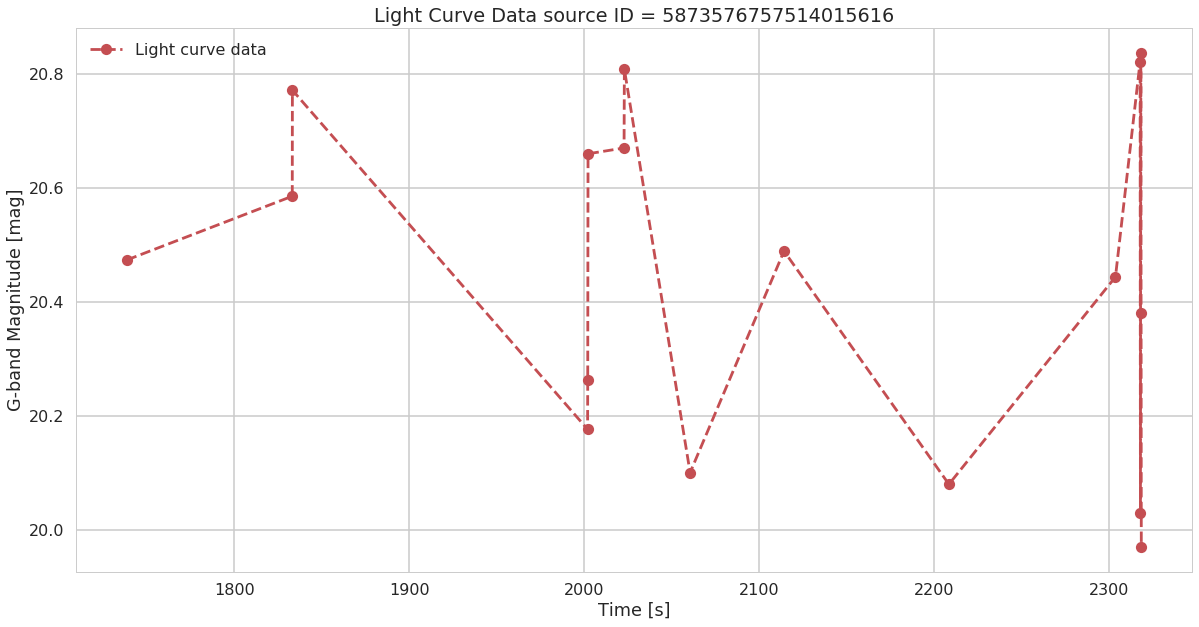

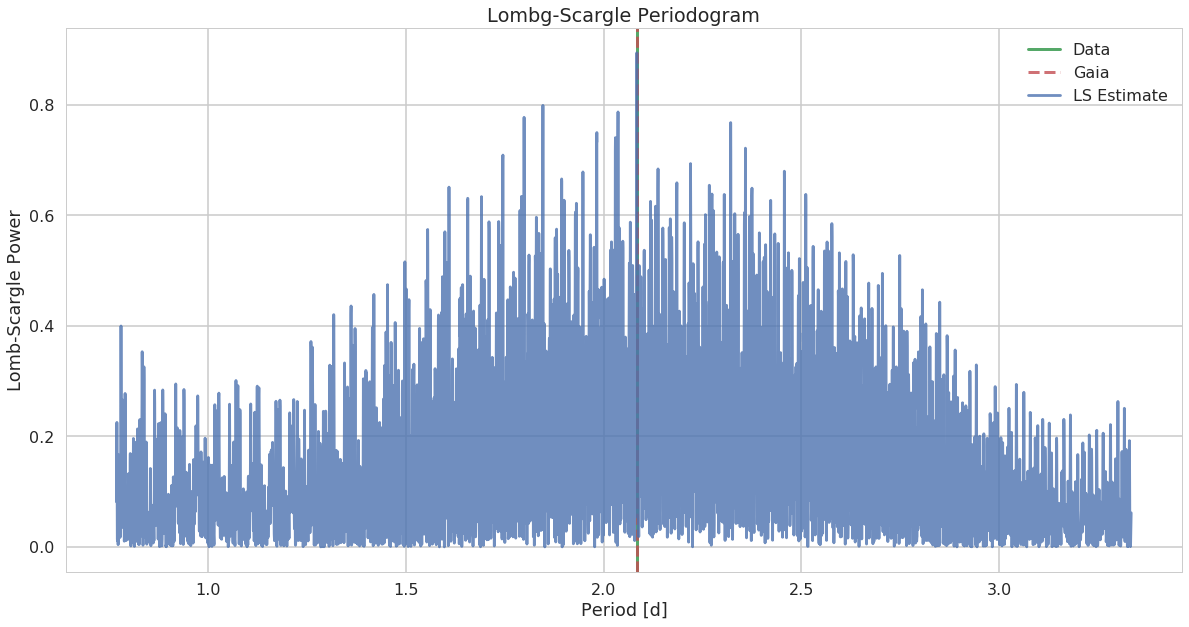

In [42]:
Estimated_period, Gaia_period, Estimated_mean_mag, Gaia_mean_mag =  estimate_period()   

In [ ]:
# Checking that the ruff outlines of the methods coincides with the Gaia Catalog

print('Range of period through LS-estimate: [', np.min(Estimated_period)
      ,',',np.max(Estimated_period),']days')
print('Range of period through Gaia values: [', np.min(Gaia_period)
      ,',',np.max(Gaia_period),']days')
print('Range of period through LS-estimate: [', np.min(Estimated_mean_mag)
      ,',',np.max(Estimated_mean_mag),'] mag')
print('Range of period through Gaia values: [', np.min(Gaia_mean_mag)
      ,',',np.max(Gaia_mean_mag),'] mag')

# D)

 In this section the periods and mean magnitudes computed from the 100 light curves are compared to the values reported in the vari\_rrlyrae catalog. To evaluate how well the the estimate and Gaia value coincide the difference is plotted and the data is subjected to a box-cut. During this box cut it is assumed that the magnitude and the period are independent of one another. The range cut on the magnitude is set to $\Delta M_G = \pm 0.1$ mag and the deviation range on the period is set to $\Delta p = \pm 0.1$. These cuts are naively based upon an assumption that a 0.1 deviation is reasonable. 
 
 The colorbars indicate the spread in the density of stars

Agreement of Lomb Scargle and Gaia catalog:  62 %


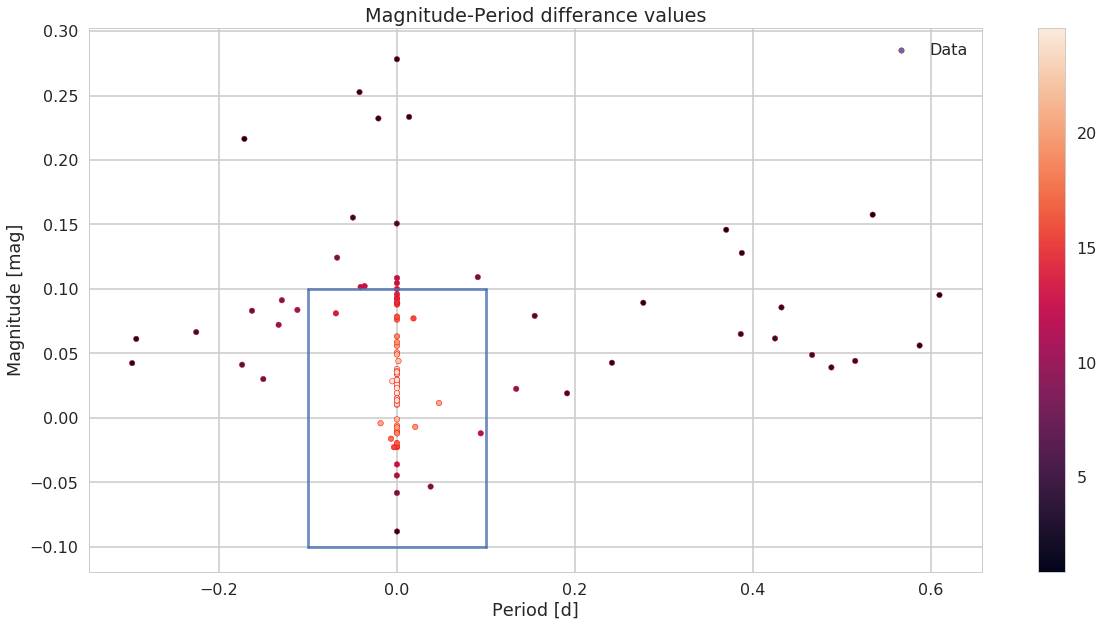

In [8]:
# Creating index array for plots
idx = np.array([i for i in range(len(Estimated_period))])

# Taking the difference of the estimates and the Gaia value
frec_diff = Estimated_period-Gaia_period
mag_diff = Estimated_mean_mag - Gaia_mean_mag

# Calculate the point density
xy = np.vstack([frec_diff,mag_diff])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(figsize = (20,10))
p = ax.scatter(frec_diff, mag_diff, c=z, s=30, edgecolor='red', label = 'Data')
plt.plot((-0.1,0.1),(0.1,0.1),'b-', (-0.1,0.1),(-0.1,-0.1), 'b-',
         (-0.1,-0.1),(-0.1,0.1),'b-', (0.1,0.1),(-0.1,0.1), 'b-', alpha = 0.8)
plt.xlabel('Period [d]')
plt.ylabel('Magnitude [mag]')
plt.title('Magnitude-Period differance values')
plt.legend()
plt.colorbar(p)

prob_count = 0
for i in range(len(Estimated_period)):
    if (abs(Estimated_period[i]-Gaia_period[i]) < 0.1) & (abs(Estimated_mean_mag[i]-Gaia_mean_mag[i]) < 0.1):
        prob_count += 1


print('Agreement of Lomb Scargle and Gaia catalog: ', round(prob_count/len(Estimated_period)*100),'%')

# 1.2 Results 
In the first part of the rapport an simple LS estimate was made on the raw light curve data, and compared to the values of the same stars in the Gaia Catalog. In section C it is found that the estimates of the period ranges from [0.31-1.50] days, and the mean magnitude ranges from [16.6-20.9] mag. The Gaia reported values have a range of period [0.36,0.77] days and [16.5, 20.9] mag. The range seemingly coincides well, but there does exist a significant fraction of internal deviations. After applying a box cut to the differences between the two estimates, it is found that the catalog and the estimate is in 62% agreement. 


# 1.3 Discussion 
Even though the general tendency of the LS estimates coincides well with the Gaia estimates, there are significant deviations. The main problem of part 1 is deciding on appropriate cuts in what should be considered agreement between the two estimates. This is done fairly rough in this section, and future improvements of this method should include a more rigorous approach to placing a restriction. Perhaps by looking more thoroughly at the error estimations, or by implementing a statistical framework that better captures the tendency of the data. 
    That they do not coincide perfectly is to be expected. The catalog values according to [Clementini et al. 2016] are initially treated by an LS method, and then subjected to more elaborate adjustments. Clementini et al also found that the Lomb-Scargle method reduces the number of large deviating period values for these specific types of variable. Furthermore, the agreement is sensitive to the choice of the cut limits, which can be easily checked and seen by looking at the _Magnitude-Period difference values_ plot. The given cut seems reasonable as it is a quite strict requirement on the estimates, but still captures the main clustering around the zero deviation. The cut serves only to exclude the outermost objects, and have one of the smaller effects on the end result amongst the spectra of possible restrictions.



# Part 2 : Quality cuts on members of the RR Lyrae

# 2.1 Methodology

## Section E

The aim of this section is to infer the RR Lyrae period-luminosity relation in the different band passes. It is for the rest of this article assumed that the periods reported in the Gaia catalog are reliable. To estimate the absolute magnitude of RR Lyraes one needs the Gaia distances. This estimation is only possible if there is not a lot of dust alongside our line-of-sight to the RR Lyrae, see discussion section for reasoning. The apparent and absolute magnitude formulas are given in the appendix. 

As is known, most of the dust in the Milky Way is in the galactic disk, at low Galactic latitude. Therefore it is made a cut in the Galactic latitude, _b_-parameter, to remove all objects in the disk. To remove objects further affected by dust and distances the following restrictions are imposed on the query to the Gaia catalog: 

1. The distance is accurately measured. I.e. the parallax errors are less than 20\%
2. The stars are located above or below the disk, with a Galactic latitude $|b|<30$ degrees.
3. The stars are relatively nearby, with distances less than 4kpc

The function get\_Gaia\_Data\_rrl2 obtains objects restricted to these cuts. 

In [9]:
def get_Gaia_Data_rrl2():
    ''' Requesting stars in Gaia source and vari_rrlyrae
    restricted by parallax, distance and placement 
    For adding B cut directly to ADQL please insert restriction:
    AND ABS(gaiadr2.gaia_source.b)  > 30 
    '''
    
    job = gaia.launch_job_async("""select * 
    FROM gaiadr2.gaia_source JOIN gaiadr2.vari_rrlyrae 
    ON gaiadr2.gaia_source.source_id = gaiadr2.vari_rrlyrae.source_id
    WHERE gaiadr2.vari_rrlyrae.pf != 'NaN'
    AND gaiadr2.gaia_source.parallax_over_error > 5
    AND gaiadr2.gaia_source.parallax > 0.25""")

    RR_lyrae_Data = job.get_results().to_pandas()
    return RR_lyrae_Data

# Quiered data without cut in galactic latitude, for later comparison
rrl2 = get_Gaia_Data_rrl2()
rrl2[0:10]

# Data after cut in galactic latitude 
rrl2_bcut = rrl2[np.abs(rrl2['b']) > 30]
print('Total objects after fist selection: ', len(rrl2_bcut))

Query finished.
Total objects after fist selection:  468


# F)

 To obtain a prior on the distance inferred from parallaxes, one would want an estimate of the distance that uses our knowledge of such Galactic structures. A catalog of distances obtained like this is Gaias catalog external.gaiadr2\_geometric\_distances. The derivation of this prior is described in [Bailer-Jones et al. 2018](https://arxiv.org/abs/1804.10121. These Bailer-Jones star are then quired based on the source IDs of the stars selected in section E.

In [10]:
def get_BailerJones_dist(cat):
    ''' Obtaining the Bailer Jones catalog distances from gaia,
    based on source_id's gathered in rrl2
    '''
    sourceID = cat['source_id'].astype('str').tolist()
    sourceID = ','.join(sourceID)

    job_url = gaia.launch_job_async("""SELECT *
    FROM external.gaiadr2_geometric_distance 
    WHERE source_id in (""" + sourceID +")")
    
    Dist_data = job_url.get_results().to_pandas()

    return Dist_data

distances = get_BailerJones_dist(rrl2_bcut)
print('Example set of Bailer Jonas catalog:')
distances[0:5]

Query finished.
Example set of Bailer Jonas catalog:


source_id        r_est         r_lo         r_hi       r_len  \
0  106337278511338880  3287.027945  3060.223572  3547.815218  399.367244   
1  584371601026374272  2160.802057  2010.555494  2334.179830  420.749978   
2  586254622063844736  2572.714709  2304.410175  2903.781201  380.151157   
3  593827920716707584  1811.171631  1676.935081  1967.632280  381.875738   
4  610579392683347968  2340.165741  2110.924105  2620.219485  388.017907   

   result_flag  modality_flag  
0            1              1  
1            1              1  
2            1              1  
3            1              1  
4            1              1

## G)

The distributions of the selected targets are plotted in Galactic coordinates, denoted as _l_ for galactic longitude and _b_ for galactic latitude. There is provided a graphical confirmation that targets in the galactic disk has been removed based upon the data quired in section F without and with applied cuts in longitude. 
The distance estimates from the Bailer-Jones catalog are then compared to a naive distance estimate found by
 
$d = \dfrac{1}{\bar{\omega}}$
 
where $\bar{\omega}$ is the parallax in arc-seconds and _d_ is the distance in parsec. To further expose the trends in the data, the indexes are sorted by increasing distances.

The colorbars indicate the spread in the density of stars.

Stars before cut in Latitude: # 1894
Stars after cut in Latitude: # 468


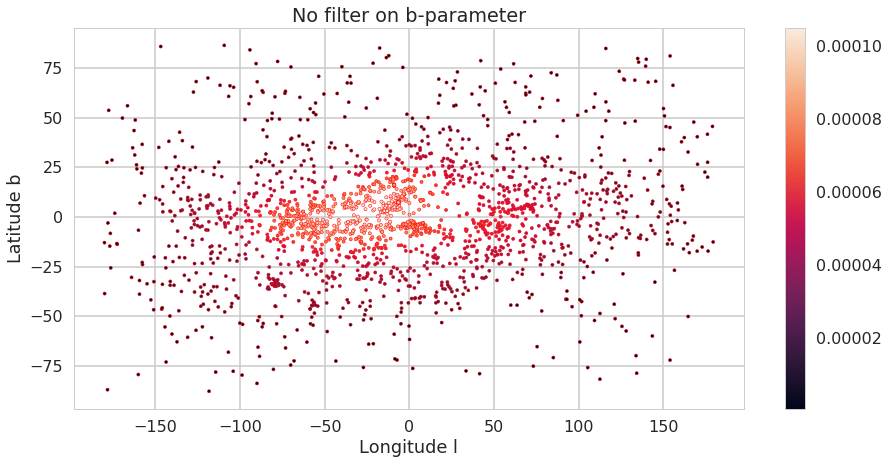

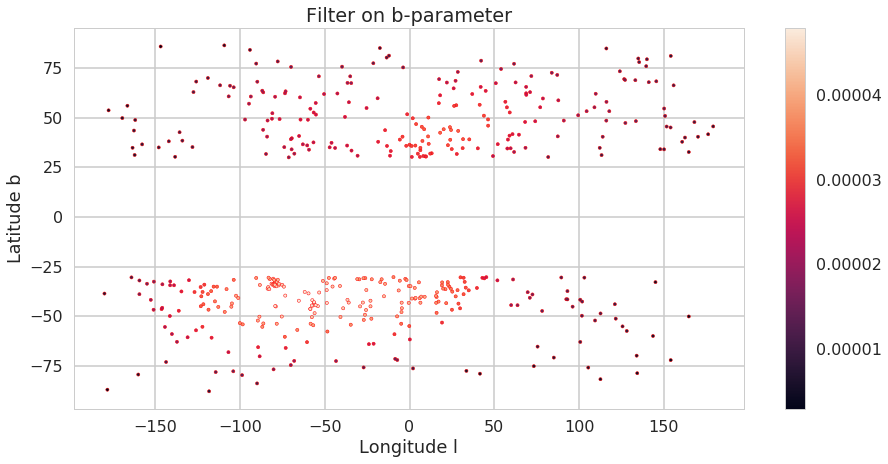

In [11]:
longitude_u, latitude_u = rrl2['l'], rrl2['b']
longitude_b, latitude_b = rrl2_bcut['l'], rrl2_bcut['b']
longitude_u = [ x if x < 180 else x-360 for x in longitude_u ]
longitude_b = [ x if x < 180 else x-360 for x in longitude_b ]

        
def plot_galactic_coords(x,y, title):
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    fig, ax = plt.subplots(figsize = (15,7));
    p1 = ax.scatter(x,y, c=z, s=10, edgecolor='red')
    #plt.legend(['datapoints'], loc = 'top')
    fig.colorbar(p1)
    plt.title(title)
    plt.xlabel('Longitude l')
    plt.ylabel('Latitude b')
    
plot_galactic_coords(longitude_u, latitude_u,'No filter on b-parameter')
plot_galactic_coords(longitude_b, latitude_b,'Filter on b-parameter')
print('Stars before cut in Latitude: #', len(longitude_u))
print('Stars after cut in Latitude: #', len(longitude_b))

### Comparing the Bailer Jones Distances and the naive inverted parallax approch

By plotting the distances along a 1d plot, it becomes evident that the distance estimates follow similar trends. The data is plotted as both unsorted and sorted to get a graphical impression of the coincidence.

Text(0.5, 1.0, 'Distance estimates sorted by increasing distance value')

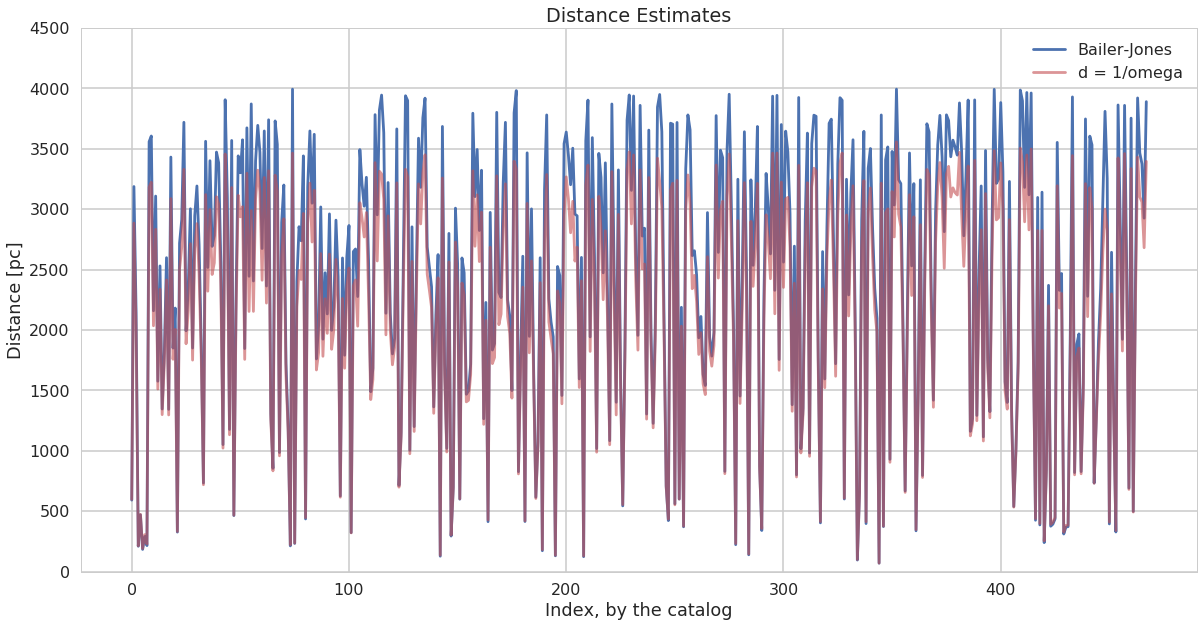

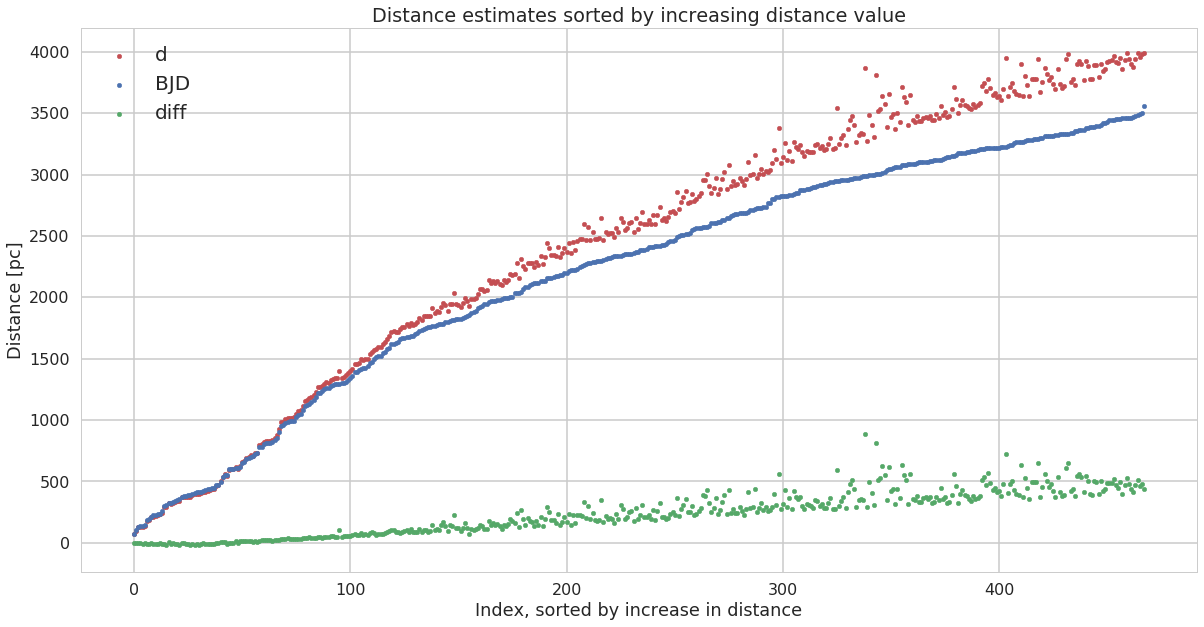

In [12]:
comb = pd.merge(rrl2, distances, on =  'source_id')

# Sorted by index
plt.figure(figsize = (20,10))
comb['r_est'] = comb['r_est']*u.pc
comb['d'] = 1/comb['parallax']*1000*u.pc
idx = [i for i in range(len(comb['d']))]
plt.plot(idx,comb['d'])
plt.plot(idx,comb['r_est'], alpha = 0.6, c = 'r')
plt.xlabel('Index, by the catalog')
plt.ylabel('Distance [pc]')
plt.title('Distance Estimates')
plt.legend(['Bailer-Jones','d = 1/omega'], loc = 'best')
plt.ylim(0,4500)



# Plot of sorted trends
comb_sorted = comb.sort_values(by = ['r_est'])

plt.figure(figsize = (20,10))
plt.scatter(idx,comb_sorted['d'], s = 20, marker = 'o', c = 'r')
plt.scatter(idx, comb_sorted['r_est'], s = 20, marker = 'o', c = 'b')
plt.scatter(idx, comb_sorted['d']-  comb_sorted['r_est'], s = 20, marker = 'o', c = 'g')
plt.legend(['d', 'BJD', 'diff'], prop={'size': 20}, 
           loc = 'best')
plt.xlabel('Index, sorted by increase in distance')
plt.ylabel('Distance [pc]')
plt.title('Distance estimates sorted by increasing distance value')


## Section H
The period is plottet vs. the absolute G-band magnitude for all stars returned by the query of section G. A colorbar is placed to indicate the density spread of the stars location.

Stars before any cuts:  468


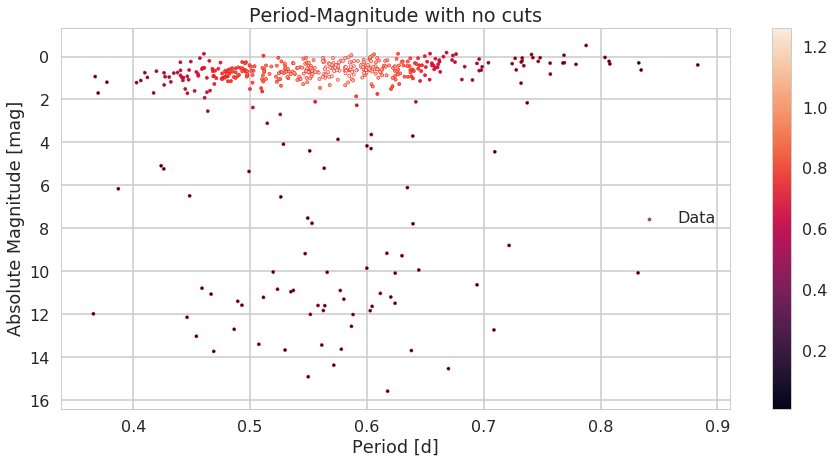

In [13]:
appearent_mag = comb['phot_g_mean_mag']
comb['absolute_mag'] = appearent_mag + 5*np.log10(comb['parallax']/100) 
period = comb['pf']

print('Stars before any cuts: ', len(comb))

def plot_PM(x,y,title):
    plt.figure(figsize = (15,7))
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)
    p = plt.scatter(x, y, c=z, s=10, edgecolor='red')
    plt.legend([ 'Data'], loc = 'right', fancybox = True)
    plt.colorbar(p)
    plt.xlabel('Period [d]')
    plt.ylabel('Absolute Magnitude [mag]')
    plt.title(title)
    plt.gca().invert_yaxis()
    
plot_PM(period,comb['absolute_mag'],'Period-Magnitude with no cuts')

## Section I


To remove the unreliable fraction of the stars that scatter far off from the median relation cuts are made according to the two following relations:

Cut $C_1$:

$
 	u < 1.2\times max(1, exp(-0.2(G-19.5)))
$

 where u is a unit weight error and G being the apparent magnitude. Cut $C_2$:
 

$
 	1.0+0.015(G_{BP}-G_{RP})^2 < E < 1.3 + 0.06(G_{BP}-G_{RP})^2
$

 Where E is the BP/RP excess factor estimated from the comparison of the sum of integrated BP and RP fluxes with respect to the flux in the G band.:
 
These cuts are taken from [Lindgren et al. 2018](https://arxiv.org/abs/1804.09366) More information about the cuts can be found in the appendix of the Lindgren article, under the same name. 
 
 The period-luminosity relation is plotted again to evaluate how many objects the cuts removed. 

Stars after first cut:  428
Stars after second cut:  409


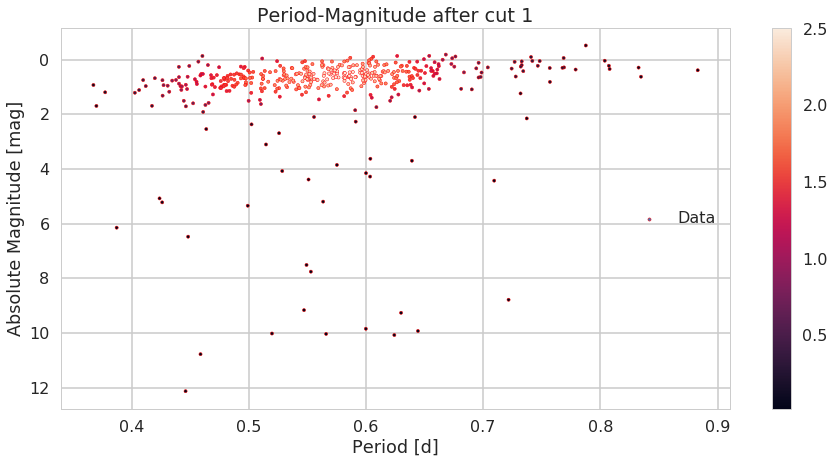

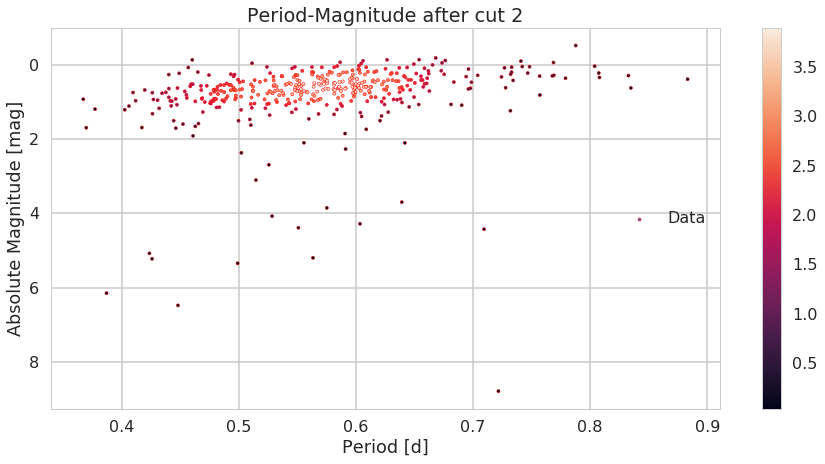

In [14]:
# CUT 1

u = np.sqrt(comb['astrometric_chi2_al']/(comb['astrometric_n_good_obs_al']-5))
cut_1 = comb[u < 1.2*np.maximum(1,np.exp(-0.2*(comb['phot_g_mean_mag']-19.5)))]
print('Stars after first cut: ', len(cut_1))

cut_1['abs_mag']= cut_1['phot_g_mean_mag'] + 5*np.log10(cut_1['parallax']/100) 

plot_PM(cut_1['pf'],cut_1['abs_mag'],'Period-Magnitude after cut 1')

# CUT 2

less = 1.0 + 0.015*(cut_1['phot_bp_mean_mag']-cut_1['phot_rp_mean_mag'])**2
more = 1.3 + 0.06*(cut_1['phot_bp_mean_mag']-cut_1['phot_rp_mean_mag'])**2
E = cut_1['phot_bp_rp_excess_factor']
cut_2 = cut_1[(less < E) & (E < more)]
print('Stars after second cut: ', len(cut_2))

appearent_mag = cut_2['phot_g_mean_mag']
absolute_mag = appearent_mag + 5*np.log10(cut_2['parallax']*100) 

plot_PM(cut_2['pf'],cut_2['abs_mag'],'Period-Magnitude after cut 2')

## Section J
To remove the final "bad" objects in the set a cut is made on all objects with a absolute G magnitude grater than a threshold of G = 2 mag. Then the period-magnitude relation is plotted, including error bars on the absolute magnitude due to distance uncertainties. The uncertainty is given by

$
 	\sigma_{dist} = 5\sqrt{(\dfrac{\sigma_{p}}{p\log_{10}(10)})^2}
$

where $\sigma_p$ is the error of the parallax, and $p$ is the parallax. See appendix for derivation. 


Stars after second cut:  390


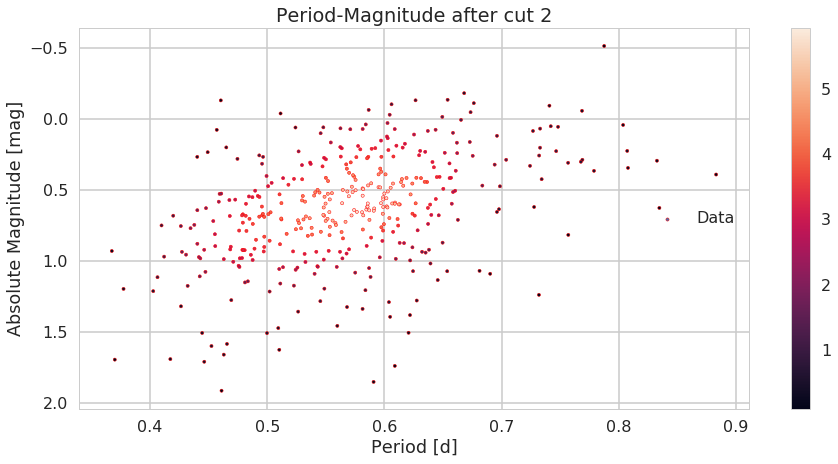

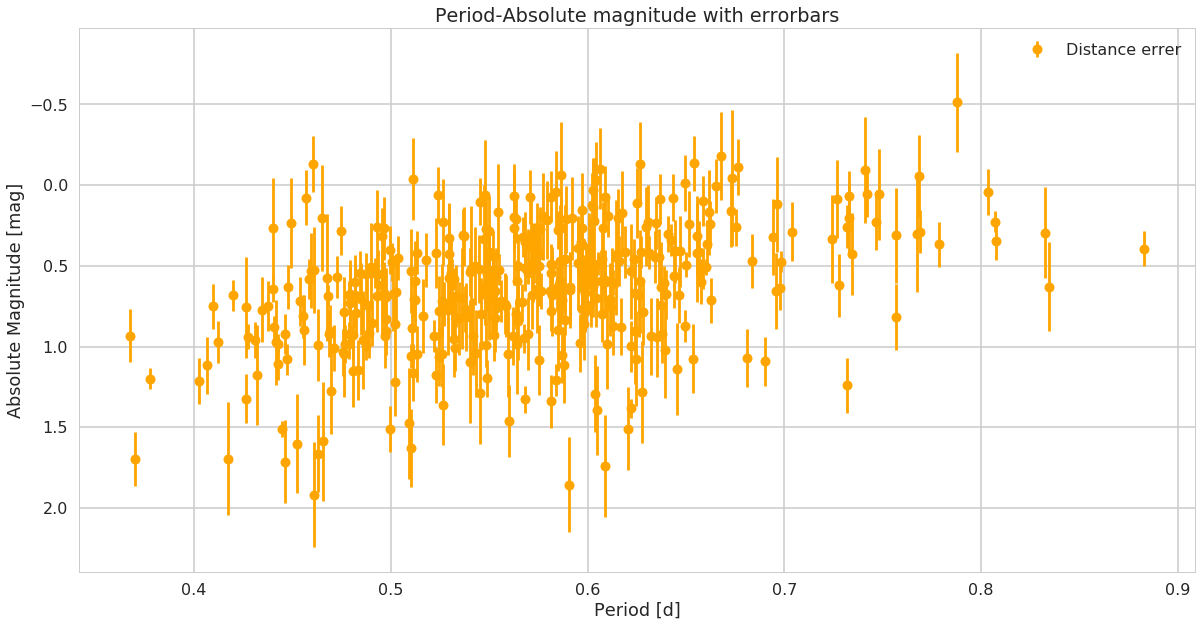

In [15]:
""" Cut 3: Crude cut of upper limit in absolute magnitude G
"""
Treshold = 2
cut_3 = cut_2[cut_2['abs_mag'] < Treshold]
print('Stars after second cut: ', len(cut_3))


""" Estimating the errors in the absolute magnitude
"""

cut_3['phot_g_mean_mag_error_sq'] = (1.09*cut_3['phot_g_mean_flux_error']/(cut_3['phot_g_mean_flux']*np.log(10)))**2
cut_3['distance_error_sq'] =  (5*cut_3['parallax_error']/(cut_3['parallax']*np.log(10)))**2
cut_3['abs_mag_error'] = np.sqrt(cut_3['phot_g_mean_mag_error_sq'] + cut_3['distance_error_sq'])


""" Plots
"""

plot_PM(cut_3['pf'],cut_3['abs_mag'],'Period-Magnitude after cut 2')

clone_cut3_sort = cut_3.sort_values(['pf'])
y_err = np.sqrt(clone_cut3_sort['distance_error_sq'])
plt.figure(figsize = (20,10))
#plt.plot(clone_cut3_sort['pf'], clone_cut3_sort['abs_mag'], 'b', ms = 30, marker = '.', ls = 'none');   
plt.errorbar(clone_cut3_sort['pf'],clone_cut3_sort['abs_mag'],ls = 'none', yerr = y_err, marker='o', ms=10, c='orange', label='Distance error')

plt.gca().invert_yaxis()
plt.xlabel('Period [d]')
plt.ylabel('Absolute Magnitude [mag]')
plt.title('Period-Absolute magnitude with errorbars')
plt.legend(['Distance errer', 'Data'], loc = 'best')



## 2.2 Results 
In part 2 there is initially found 468 stars by the restrictions listed under section E. In section G, it is found that the cut in latitude reduces the amount of stars from 1894 to 468. By plotting the distances along a 1d plot, it becomes evident that the distance estimates follow similar trends. Although the naive approach seems to be shifted downwards relative to the Bailer-Jones estimate. In the sorted plot the trends become more clear. As the distance increase, so does the deviation between the two approaches. The naive approach have an increasingly larger value than the Bailer Jones catalog, the larger the distance becomes.
   
In section H the period vs absolute G-band magnitude for all stars quired in section G was plotted for the 468 stars. It is evident that the majority of the stars have an absolute magnitude in the range of [0, 2] mag, and a period in between [0.3, 0.9] days. Although it is evident that a non-negligible fraction of the stars are scattered far off this median relation. 

After making the cuts of relation C$_1$ and $C_2$ it becomes evident that the cut's have removed quite a few of the stars. Cut 1 removed 40 stars, and cut 2 removed 19 more, leaving a total of 409 stars. The scatter has decreased, for instance it is evident that the stars with the largest magnitudes are completely removed, I.e. the absolute magnitudes larger than 9 mag. After applying the last cut in section J, the final amount of stars left are 390. The errorbarplot of the period-magnitude relation illustrates the remaining samples with their respective errors estimated from error propagation in the distance parameter. It is evident that the individual errors fluctuate in magnitude. 


## 2.3 Discussion
In section E the Gaia distances are used to estimate the absolute magnitude of the RR Lyrae. As stated, this estimation is only possible if there isn't a lot of dust between us and the RR Lyrae. This is because the nature of dust found along the sight-line is such that it will cause objects to appear fainter as a function of the emitted wavelength of light. This is known as the extinction law. I.e. the dust absorb and emit the electromagnetic radiation, and scatters it away from our direct line of sight. Without accurate measurements of the electromagnetic radiation, we will not be able to calculate the distance properly. A further challenge is that the dust particles laying towards the RR Lyrae have different properties than their counterparts close to our sun. Thus a proper estimation of the effect of dust becomes challenging.  

In section G a naive approach to the distance is compared to the Bailer Jones catalog distances, and there was found an increase in the deviation the larger the value of the distance. One reason for this might be that the naive approach is derived simply as the inverse of the parallax. It completely fails to take the dust and EM-distortion into account, that affects the parallax measurements. 

In section H the absolute magnitude values and periods for the RR Lyrae stars seems reasonable according to other catalog values. For example compared to the values stated in [Clementini et al. 2018]. It is reasonable to assume that the stars that scatter far off the median relation are misplaced due to incorrectly measured parallaxes. In removing these objects, the most outlying stars are taken out of account. The risk of such a process, especially in removing all stars over a naive threshold for G, is to remove stars that should have been counted as a member of the group. Still it seems more reasonable to risk having some members taken out of account, to remove members that absolutely do not belong.

# Part 3:  Period-Luminosity relation in different band passes and Bayesian model fitting

In this part of the article we look at how to make logaritmic line fits to 

 1. The G-band period vs absolute magnitude relations in the Gaia selection from the final cuts of part 2
 2. The G-ban period vs absolute magnitude relations in the Wise survey data for the same stars as in [1]
 3. The period-color relation for the RR Lyrae stars in the Gaia bands
 

## Section K
To fit a line to the G-ban period vs. absolute magnitude relation the following model is assumed

$	M_G = a\times log(P) + b$

where a and b are free parameters. A further explanation of the Bayesian approach to the model fitting is found in the appendix. The likelihood function and priors are both clearly stated in the functions _lnlike_ and _lnprior_, and an MCMC sampleris used to explore the covariances between the different model parameters. The prior is taken as uninformed.  The initial conditions for a and b is sat to a = -2 and b = -1, as seems reasonable after analyzing the first drafts of the period-magnitude plots. 

### Intrinsic scatter
The intrinsic scatter describes the sidual about the best-fit period-magnitude relation in each waveband. This can not be accounted for by instrumental photometric error [Klein & Bloom, 2014]. An implementation can be done as noted in this [blogpost](https://dfm.io/posts/fitting-a-plane/). I did not have enough time to completely implement it in this function, but it could have been done fairly easily by inlcuding one more parameter in the function.

In [16]:
""" Line fit tools
"""

def lnlike(theta, x, y, yerr):
    """ Likelihoof Function
    Yields the log-likelihood, assuming theta = {a,b}.
    Takes theta and the data (x,y,error in y).
    Returns the log-likelihood value for entire dataset, given one value of a and one og b.
    """
    a, b = theta
    model = a *np.log10(x) + b
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprior(theta):
    """ Takes theta as argument {a,b}, and 
    returns log-prior if priors are within bounds or -infty if priors are outside of bounds.
    """
    a, b = theta
    if -5.0 <= a <= 5.0 and -5 <= b <= 5:
        return 0.0
    return -np.inf


def lnprob(theta, x, y, yerr):
    """ Takes in theta = {a,b} and data (x,y,error in y). 
    Returns a log probability if finite, and -inf if not finite
    """
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr)


def fit_G_band_line(seed, x, y_data, niterations, intrinsic_scatter_param, y_err):
    """ 
    
    Implementing burnin by removing the first 200 steps
    They are still sensitive to the initial conditions
    """
    # Sampeling the posterior using emcee
    rnd = np.random.RandomState(seed)
    
    ndim, nwalkers = 2, 16
    initial_a, initial_b = -2, -1
    pos = [(initial_a, initial_b) + 1e-4*rnd.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(x, y_data, y_err))
    
    start_time = time.time()
    sampler.reset()
    sampler.run_mcmc(pos, niterations)

    end_time = time.time() - start_time
    print(f"This run took: {np.around(end_time,2)} seconds")

    return sampler, y_err

    
""" Plotting functions for the line fit
"""


def m_b_step_plot(sampler):
    print(sampler.chain.shape) # ndim, nwalker, # of parameters
    print(sampler.flatchain.shape) # ndim * nwalker, # of parameters 

    fig, ax = plt.subplots(2,1, figsize=(5,10))
    y_labels = ['$a$', '$b$']
    x_labels = 'step'
    ax[0].set_title('Parameter Value vs. Step Number for each walker')
    for i,j in enumerate(sampler.chain[0,0,:]):
        ax[i].plot(sampler.chain[:,:,i].T, alpha=0.8, lw=0.5)
        ax[i].set_ylabel(y_labels[i])
        ax[i].set_xlabel(x_labels)
    plt.subplots_adjust(hspace=0.4)
    
    plt.figure()
    plt.plot(sampler.lnprobability.T)
    plt.ylabel('lnP')
    plt.xlabel('step')
    plt.title('lnP vs. step number')
    plt.ylim(-50, sampler.lnprobability.max()*1.5)
    #plt.ylim(sampler.lnprobability.min(), sampler.lnprobability.max()*1.5)

    
def corner_plot(sampler):
    ndim, nwalkers = 2, 16
    burn_in = 200
    samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
    print(f"corner version={corner.__version__}")
    fig = corner.corner(samples, labels=["$a$", "$b$"],quantiles=[0.16, 0.84])    


def draws_posterior(sampler,x,y_data,y_err):
    burn_in = 200
    ndim, nwalkers = 2, 16
    samples = sampler.chain[:, burn_in:, :].reshape((-1, ndim))
    plt.figure(figsize = (20,10))
    # create an array of x values
    xl = np.linspace(0.3, 0.9,1e4)
    # randomly draw 50 points from my posterior (i.e., the MCMC chain)
    # and plot them as thin black lines
    for a, b in samples[np.random.randint(len(samples), size=50)]:
        plt.plot(xl, a*np.log10(xl)+b, color="k", alpha=0.1)
        

    # plot the fake data with error bars
    plt.errorbar(x, y_data, yerr=y_err, ls='none', marker='o', ms=1, c='orange', label='Errorbars')
    plt.plot(x, y_data, 'b', ms = 10, marker = '.', ls = 'none', label = 'Data');        
    
    #set some limits on the plot
    plt.xlabel("$Period [d]$", fontsize=20)
    plt.ylabel("$Magnitude [mgs]$", fontsize=20)
    #plt.xlim(-1, 0.95)
    #plt.ylim(-2,3)
    plt.tight_layout()
    plt.gca().invert_yaxis()
    

    #compute summary statistics: 50, 16, 84 percentiles
    a_mcmc, b_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    x_ar = np.linspace(0.3,0.9,len(y_data))
    plt.plot(x_ar, a_mcmc[0]*np.log10(x_ar) + b_mcmc[0], c = 'r', label = "Median Fit")
    
    plt.legend(frameon=True, fontsize=14)
    
    print(f"mcmc median, +/- for a: {a_mcmc}\n")
    print(f"mcmc median, +/- for b: {b_mcmc}")
    return a_mcmc, b_mcmc

In [17]:
sampler_rrl, y_err_in =  fit_G_band_line(420, clone_cut3_sort['pf'], 
                                         clone_cut3_sort['abs_mag'], 
                                         1000, 1e-4, y_err)

This run took: 15.66 seconds


## Section L
The traces of the MCMC walkers are then plotted to check for convergence, and the corner package is used to visualize constraints on the posterior for the fit. 

(16, 1000, 2)
(16000, 2)


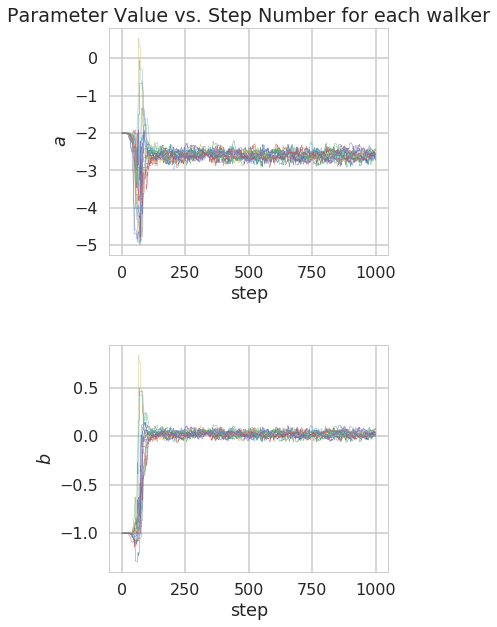

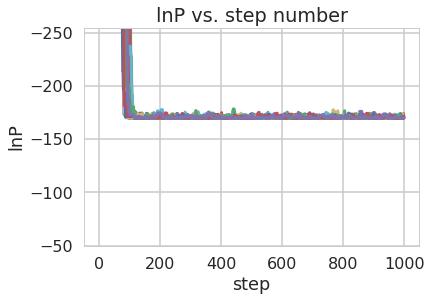

In [18]:
m_b_step_plot(sampler_rrl)

corner version=2.0.1


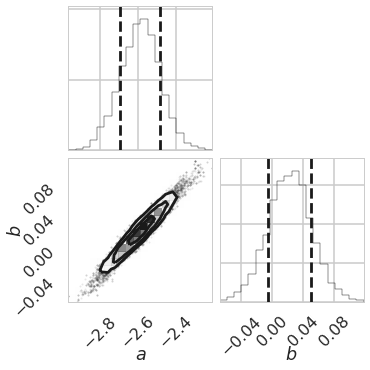

In [19]:
corner_plot(sampler_rrl)

## Section M

 50 random, independent samples from the posterior is then plottet over the data.

mcmc median, +/- for a: (-2.5857770002846423, 0.10157161606134801, 0.10874178587298733)

mcmc median, +/- for b: (0.022941440362526037, 0.02733946318444124, 0.02766042131743767)


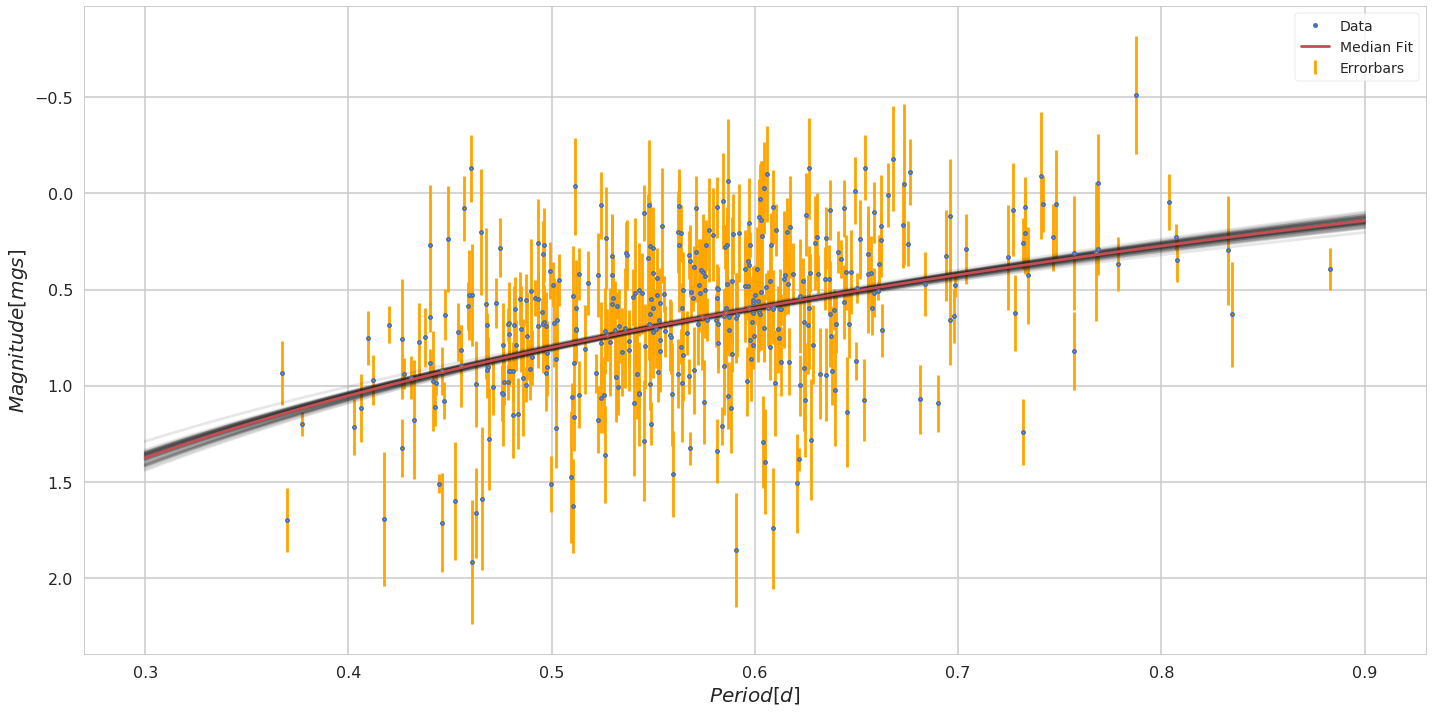

In [20]:
a_1,b_1 = draws_posterior(sampler_rrl, clone_cut3_sort['pf'], clone_cut3_sort['abs_mag'],y_err_in)


## Section N
The RR-Lyrae sample are then cross-match and compaered to the data of the stars identified by the WISE survey. The function get\_WISE obtains the data from the catalogs gaiadr2.allwise\_best\_neighbour and gaiadr1.allwise\_original\_valid.

In [21]:
def get_WISE(cat):
    ''' Submitting ADQL queries to the Gaia Database using TapPlus
    '''
    
    sourceID = cat['source_id'].astype('str').tolist()
    sourceID = ','.join(sourceID)

    job = gaia.launch_job_async("""SELECT *
    FROM gaiadr2.allwise_best_neighbour JOIN gaiadr1.allwise_original_valid
    ON gaiadr2.allwise_best_neighbour.allwise_oid = gaiadr1.allwise_original_valid.allwise_oid
    WHERE source_id in (""" + sourceID +")")
    
    
    WISEdata = job.get_results().to_pandas()
    return WISEdata

Wise_Data = get_WISE(clone_cut3_sort)
comb_2 = pd.merge(clone_cut3_sort,
                  Wise_Data, 
                  on =  'source_id')

Query finished.


## Section O

Section K-M is then reapeted for the WISE "W2" magnitude. 

In [22]:
M =  comb_2['w2mpro'] + 5*np.log10(comb_2['parallax']/100)
sampler_WISE, y_err_in_2 =  fit_G_band_line(421, comb_2['pf'],M , 1000,0.02, y_err)

This run took: 33.54 seconds


(16, 1000, 2)
(16000, 2)


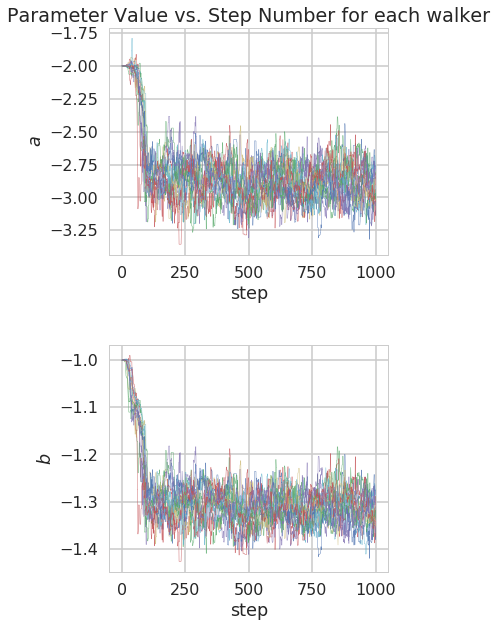

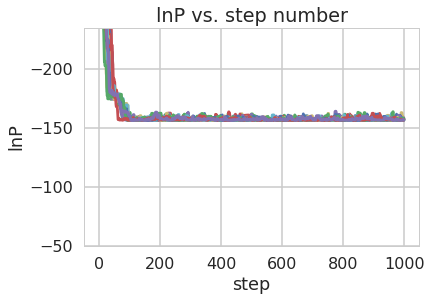

In [23]:
m_b_step_plot(sampler_WISE)

corner version=2.0.1


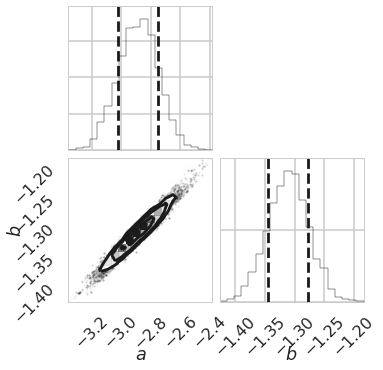

In [24]:
corner_plot(sampler_WISE)

mcmc median, +/- for a: (-2.8815724050496936, 0.1314892352588597, 0.13901700424354146)

mcmc median, +/- for b: (-1.3101199000688348, 0.033160839785155716, 0.0352679715050348)


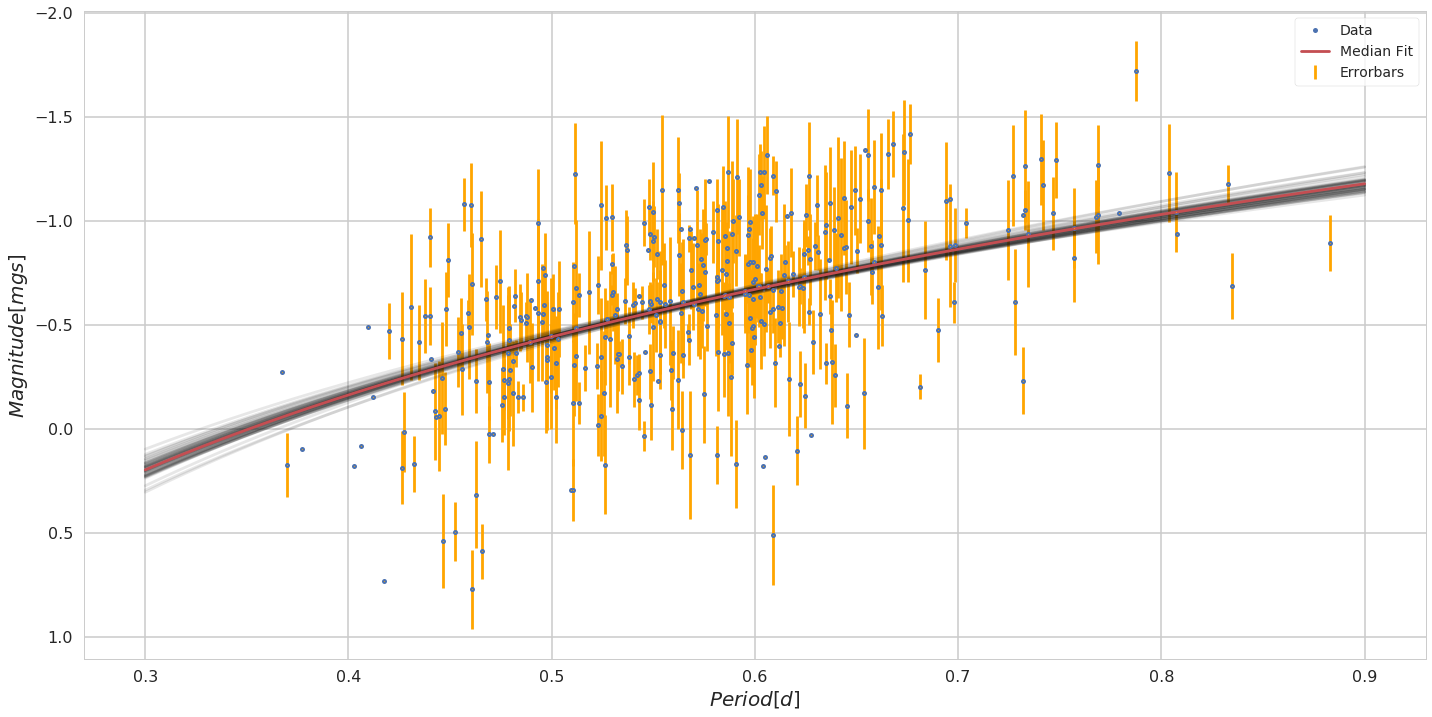

In [25]:
comb_2['error_y'] = y_err_in_2
a_2,b_2 = draws_posterior(sampler_WISE, comb_2['pf'], M, comb_2['error_y'])

## Section P

The differences between the optical and the near-infrared period-luminosity (PL) relations is that the near-infrared relation has a lower zero point value and a steeper PL relation. The entire near-infraread specter seems to be shifted approximatly 1 magnitude upwards from the optical specter. 
This might be due to the effect of the dust along the line-of-sight, that affects the scattering of light in the visible and near-infrared electromagnetic radiation differently. This also might be some of the reason why the relation curves are tilted slightly different. 


## Section Q

The [Klein & Bloom 2014](https://arxiv.org/abs/1404.4870) parameter estimates are presented in the table below alongside the parameter estimates found in this article of a period-magnitude equation

$M = a\log_{10}(P/P_0)$


| Estimates  |  W2-band a  | W2-band b  |  Gaia V/G-band a  | Gaia V/G-band b  |
|---|---|---|---|---|
| Klein & Bloom  | $-2.2337 \pm 0.1249$  |  $-0.4583 \pm 0.0112$ | $- 0.4091\pm 0.2370$  | $ 0.4319 \pm 0.0184$|
| This Article  | $-2.8816 \pm 0.1315$ | $-1.310 \pm 0.0342$  | $-2.5858 \pm 0.1079$  | $0.0229 \pm 0.0263$   |



In both cases there seems to be a shift downards from the Klein and Bloom estimations. The Gaia G band estimations seems to deviate a bit more than the Gaia G band from the Klein and Bloom values without any other immidiatly clear systematic tendancies in the deviation. The deviations that occure here might be due to the the approach undertaken above, where the intrinsic scattering and other factors are not taken into accound. 



## Section R

Following a similiar procedure as section K-M, a period-color relation is derived for the RR Lyrae stars in the Gaia bands. The uncertainties  of the BP and RP flux are calculated as


$\sigma_{tot} = \dfrac{2.5}{\log(10)}  \sqrt{ (\dfrac{\sigma_{bp}}{G_{bp}})^2 +(\dfrac{\sigma_{rp}}{G_{rp}})^2}$


This error is estimated in the same manner as infered in the appendix, section for error propagation. 

In [26]:
distance_error = (5*comb_2['parallax_error']/(comb_2['parallax']*np.log(10)))**2
y_fbp = (comb_2['phot_bp_mean_flux_error']/comb_2['phot_bp_mean_flux'])**2
y_frp = (comb_2['phot_rp_mean_flux_error']/comb_2['phot_rp_mean_flux'])**2
y_error = 2.5/np.log(10)*np.sqrt(y_fbp + y_frp+distance_error)

sampler_rrl_period_color, y_err_in_3 =  fit_G_band_line(422, comb_2['pf'], comb_2['bp_rp'] 
                                            , 1000, 0, y_error)


This run took: 15.49 seconds


(16, 1000, 2)
(16000, 2)


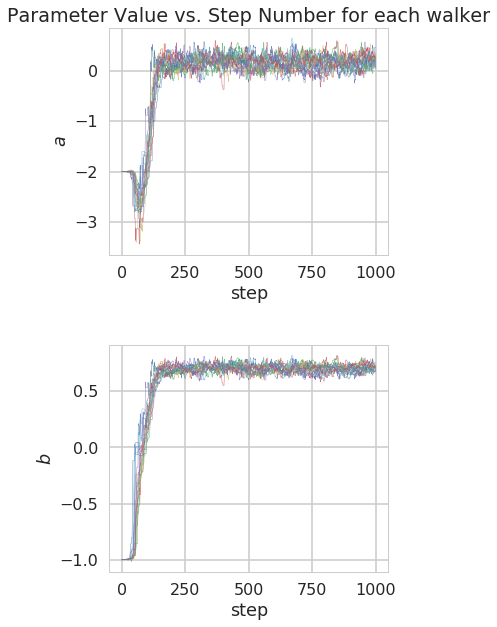

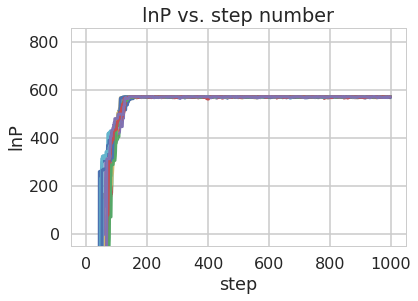

In [27]:
m_b_step_plot(sampler_rrl_period_color)

mcmc median, +/- for a: (0.1625157526256697, 0.12772345755213615, 0.12901506993297523)

mcmc median, +/- for b: (0.699732813742103, 0.03322353624492658, 0.033460817073417526)


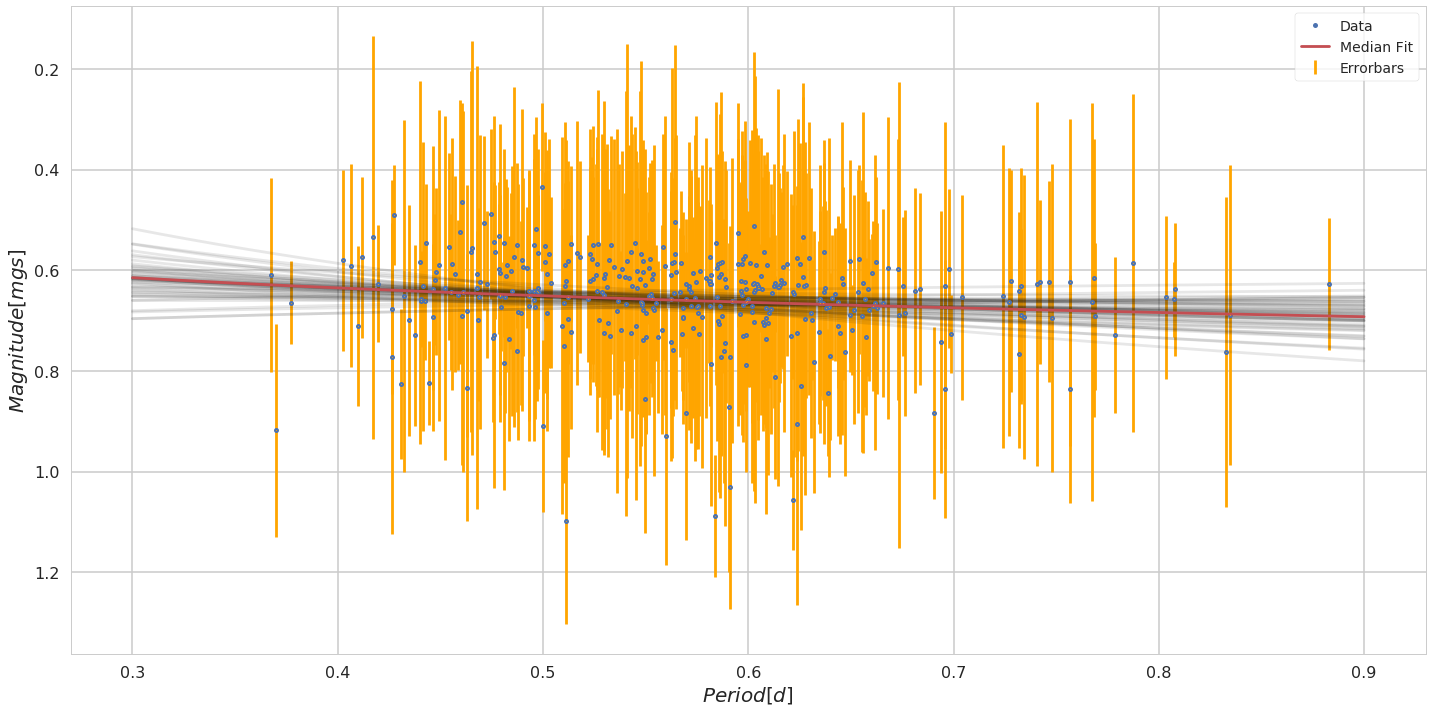

In [28]:
comb_2['y_err_in_3'] = y_err_in_3
a_3, b_3 = draws_posterior(sampler_rrl_period_color, comb_2['pf'],comb_2['bp_rp'], comb_2['y_err_in_3'])


# 3.2 Results 

In this section loarithmic models were fitted to the period-luminosity relations for the Gaia and the Wise survey data, as well as the period-color relation for the RR Lyrae stars in the Gaia Bands. It was clearly sceen in all three cases that the parameters converged to a certain intervall of values. In all three cases values for the parameters were found that did not deviate to far off from other litterature values, but that had minor differences. The uninformed prior futhermore turned out to be suitable for this set of data. 




In the end, the following three models were found

The Gaia G-band:

$ M_G = -2.5858\log[P/day] + 0.0226 $

The Wise W2 band

$ M_G = -3.1338\log[P/day] - 1.3802$

The period-color relation for RR Lyrae 

$ G_{BP/RP} = 0.1625\log[P/day] + 0.6997$



# 3.3 Discussion

In order to more comprehensivly understand the final period-color relation of the RR Lyrae, a more thourholgy analysis of the deviations in the parameters of the Wise and Gaia data in relation to litterature values should be undertaken. It is also left to investigate wheter or not the median values of all the estimated parameters is the acctual best fit to the curve, or if more comprehensive analysis should be introduced. 


# Part 4: Color Extinction and Aitoff Projection

The aim of this last part is to draw a dust map of the Milky Way using the color excess factors, and compare the result to other known dust-maps such as the SFD. All galactic coordinates are mapped into an Aitoff projection.

## Section S 

The full Gaia RR Lyrae catalog is then downloaded without any restrictions on parallaxes, galactic latitude etc., and the data is cross matched with the Gaia source catalog.

In [29]:
def get_Gaia_Data_rrl3():
    ''' Submitting ADQL queries to the Gaia Database using TapPlus
    '''
    job = gaia.launch_job_async("""select * 
    FROM gaiadr2.gaia_source JOIN gaiadr2.vari_rrlyrae 
    ON gaiadr2.gaia_source.source_id = gaiadr2.vari_rrlyrae.source_id
    """)

    RR_lyrae_Data = job.get_results().to_pandas()
    return RR_lyrae_Data



rrl3 = get_Gaia_Data_rrl3()
rrl3[0:10]
print('Total objects: ', len(rrl3))

Query finished.
Total objects:  140784


## Section T

To calculate the color excess

$	E(G_{BP}-G_{RP})_{observed} - (G_{BP}- G_{RP})_{intrinsic}$

This difference between the intrinsic and observed colors constitutes a measurment of the reddening of the star, where the intrinsic color is the color you would expect if there were no reddening due to dust ([Schlafly & Finkbeiner 2011](https://arxiv.org/abs/1012.4804)). This factor can be calculated by taking fit to the period-color relation and apply it to the period. The selected parameters for a and b is choosen to be the mean values of all the fits. 

$
	E_{intrinsic} = 0.17\times \log(Period) + 0.70
$

Then, assuming $R_G = 2.0$, the G-band extinction for each star is calculated as 

$
	A_G = R_GE(G_{BP}-G_{RP}) =2 E(G_{BP}-G_{RP})
$

In [30]:
# Dropping all frames including na for efficiency 
rrl3_cut = rrl3.dropna(subset = ['pf','bp_rp'])

# Calculating intrinsic color and the color excess 

intrinsic_color = a_3[0]*np.log10(rrl3_cut['pf'])+b_3[0]
rrl3_cut['color_excess'] = rrl3_cut['bp_rp']- intrinsic_color


# Calculating the AG factor

AG = 2*rrl3_cut['color_excess']
rrl3_cut['AG'] = AG

## Section U
A plot of the estimated color extinction and the catalog values from Gaia source is plotted against the period. 

(0.3, 0.9)

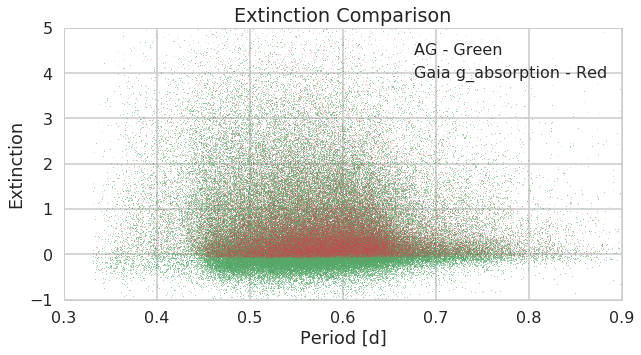

In [31]:
plt.figure(figsize = (10, 5))
plt.scatter(rrl3_cut['pf'], AG, s = 0.1, c = 'g')
plt.scatter(rrl3['pf'], rrl3['g_absorption'], s= 0.1, c = 'r',alpha = 0.4)
plt.title('Extinction Comparison')
plt.xlabel("Period [d]")
plt.ylabel("Extinction")
plt.legend(["AG - Green", "Gaia g_absorption - Red"])
plt.ylim(-1,5)
plt.xlim(0.3,0.9)

## Section V

Then a 2D map of the color extinction is then plotted as a function of galactic logitude and latitude on an Aitoff projection using the standard Aitoff relations:

$	x = \dfrac{2\cos\phi\sin\dfrac{\lambda}{2}}{sinc(\alpha)}$,    

$	y = \dfrac{\sin \phi}{sinc(\alpha)}$

Where

$	\alpha = \arccos(\cos\phi\cos\dfrac{\lambda}{2})$

$\phi$ corresponds to the galactic latitude b and $\lambda$ to the galactic longitude l. To remove the large-scale structures with reddening that looks clearly wrong, cuts are made to the set of stars. The objects with BP/RP excess errors and photometric signal-to-noise errors larger than 10 \% are removed. Also all the objects with extinction values belove zero is found unreliable and removed. 

In [32]:
llambdau = rrl3_cut['l']*np.pi/180
theta = rrl3_cut['b']*np.pi/180
llambda= np.array([ x if x < np.pi else x-2*np.pi for x in llambdau])
alpha = np.arccos(np.cos(theta)*np.cos(llambda/2))

rrl3_cut['aitoff_x'] = 2*np.cos(theta)*np.sin(llambda/2)/np.sinc(alpha)
rrl3_cut['aitoff_y'] = np.sin(theta)/np.sinc(alpha)

In [33]:
#Cut 1: Standardized  
rrl3_cut2 = rrl3_cut[(rrl3_cut['phot_rp_mean_flux_over_error'] > 10) & 
                     (rrl3_cut['phot_bp_mean_flux_over_error'] > 10) & 
                     (rrl3_cut['AG'] > 0)]



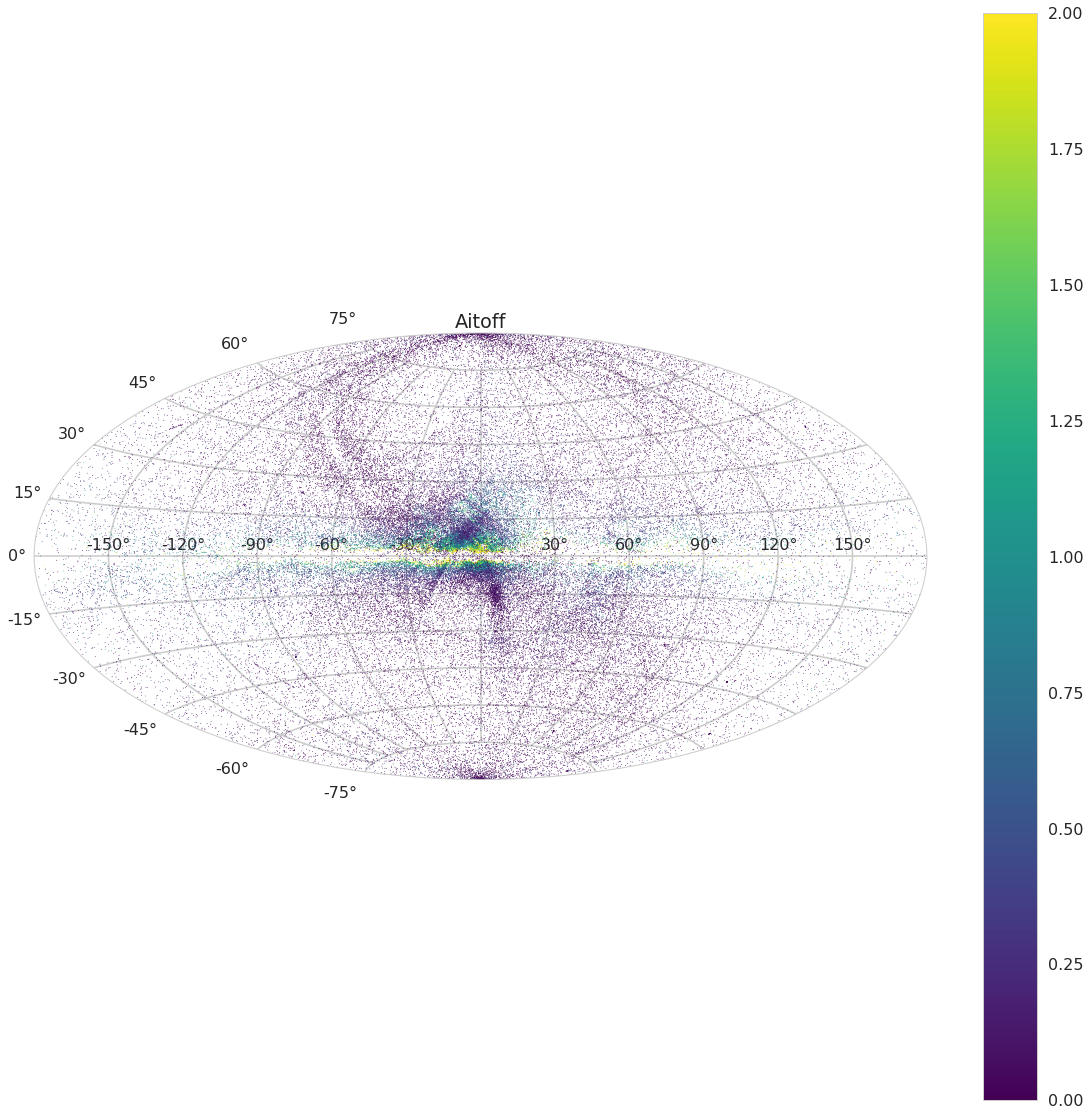

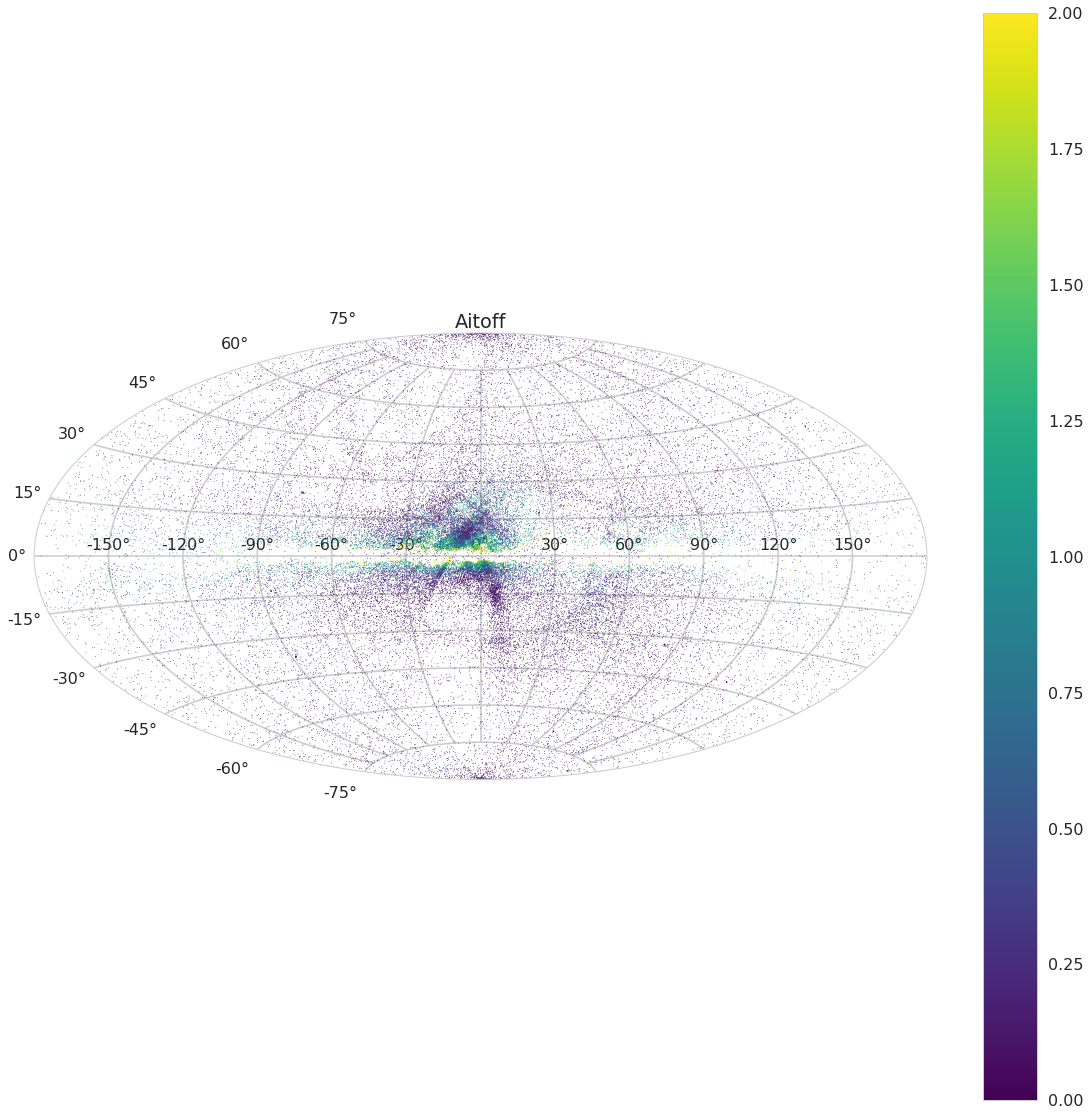

In [34]:
# Before Cuts

plt.figure(figsize = (20,20))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff")
plt.scatter(rrl3_cut['aitoff_x'], rrl3_cut['aitoff_y'], c = rrl3_cut['color_excess'], s = 0.1, cmap = 'viridis',vmin = 0, vmax = 2)
plt.colorbar()
plt.grid(True)

# After Cuts

plt.figure(figsize = (20,20))
plt.subplot(111, projection="aitoff")
plt.title("Aitoff")
plt.scatter(rrl3_cut2['aitoff_x'], rrl3_cut2['aitoff_y'], c = rrl3_cut2['color_excess'], s = 0.1,cmap = 'viridis', vmin = 0, vmax = 2)
plt.colorbar()
plt.grid(True)

## Section W

For the very last Section the "SFD" Galactic dust map is downloaded for comparison with the tenuation map produced above. The SFD optical reddening map with the color extinction is plotted in an Aitoff projection, sampled at the same positions as the RR Lyrae map. 

In [43]:
""" Maiking an Aitoff projection based on the restrictions done to the selection
of quality data
"""

llambdau = rrl3_cut2['l']*np.pi/180
theta = rrl3_cut2['b']*np.pi/180
llambda= np.array([ x if x < np.pi else x-2*np.pi for x in llambdau])
alpha = np.arccos(np.cos(theta)*np.cos(llambda/2))

rrl3_cut2['aitoff_x'] = 2*np.cos(theta)*np.sin(llambda/2)/np.sinc(alpha)
rrl3_cut2['aitoff_y'] = np.sin(theta)/np.sinc(alpha)

""" Downloading the SFD map
"""
dustmaps.sfd.fetch()
l = rrl3_cut2['l'].values*u.deg
b = rrl3_cut2['b'].values*u.deg

coords = SkyCoord(l,b, frame='galactic')
sfd = SFDQuery()
ebv = 2*sfd(coords)

Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.
Checking existing file to see if MD5 sum matches ...
File exists. Not overwriting.


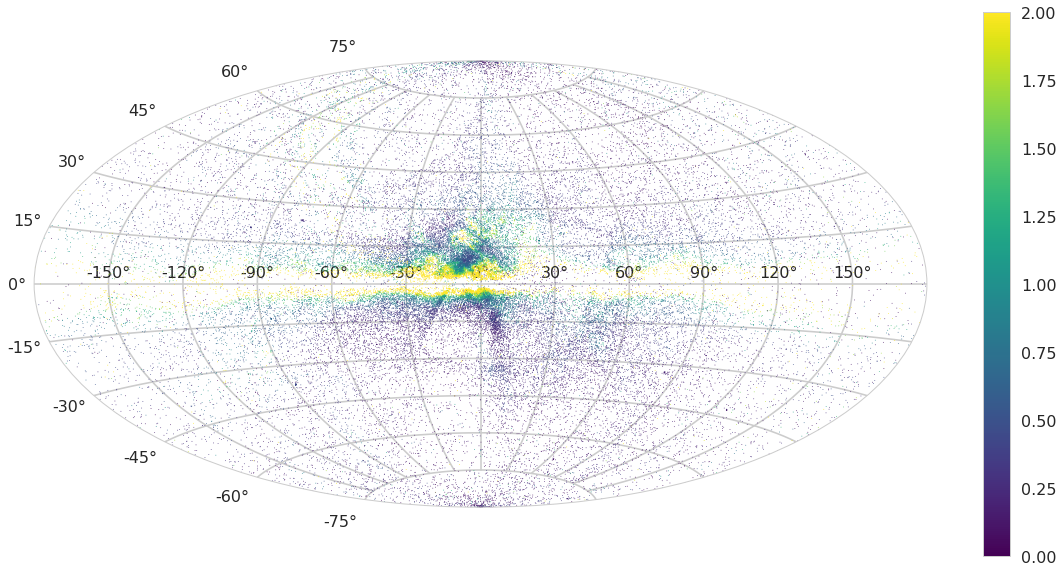

In [44]:
plt.figure(figsize =(20,10))
plt.subplot(111, projection="aitoff")
plt.scatter(rrl3_cut2['aitoff_x'],rrl3_cut2['aitoff_y'],c = ebv, 
            s = 0.1, cmap = 'viridis', vmin = 0, vmax = 2)
plt.colorbar()

# 4.2 Results 

It is found a significant deviation between the $A_G$ factor estimated in this article and the G$_{absorption}$ values provided by Gaia. The two estimates follow the same large scale tendencies, but the intermediate differences are evident just by looking at the plot. 

As assumed in the previous sections, it is clearly seen in the Aitoff projections of both the data derived in this article and the SFD map, that most of the dust in the galaxy lays along the galactic disk. The SFD maps shows the same large-scale tendencies as the map produced in this article. As well, a lot of the smaller scale details seems to appear in both cases. Like for example the curvation of the dust density along the center line in the latitude. The main difference between the two dust maps appear to be the amount of dust in the central regions of the map. The SFD shows a larger and broader amount of dust along the galactic disk. The tendency of the dust to increase as one approaches the center is present in our map as well, but in a more discrete way. The yellow region of the map is much smaller and more faint in our version. 

# 4.3 Discussion

That the distribution of RR Lyrae stars in the catalog is not all uniform is not unsurprising. The physics of the galaxy forms clusters and regions of higher density, and regions of lower populations. The RR Lyrae have in common that they live along the instability strip in the HR diagrams, but they can still occur with some probability along multiple of the clusters in the Milky way.

One can furthermore try to understand what causes the deviations between the SFD map and our map. It seems to be that the main factor who sets the maps are part is a scaling factor in the dust value. This might be correlated to the assumption of the $A_g = 2$ factor applied to both our map and as a scaling factor in the SFD.  As was seen in section U, there are significant deviation between our A$_G$ factors and the once reported in Gaia. This serves to illustrate how the estimations done in this rapport can deviate form other more recognized catalog values. Further investigation is required to determine if this is the case. Another source of insecurities is the approximation used to estimate the intrinsic $G_{BP/RP}$. Error done in the parameter estimation will cause a systematic fault in this factor, causing deviations from the methods used to derivate the SFD dust map.

# 5. Conclusion 

This article started with using the Lomb-Scargle method for analyzing periodicity of the RR Lyrae. It found a coincidence of 
62 % in relation to the prior placed from the Gaia vari_rrlyrae catalog. This coincidence was unsurprising, as the Gaia catalog data initially was subjected to a LS-approach and then fine tuned by further restrictions. In part 2 of this article quality cuts based on what could be considered reliable data restricted the members taken into account of the RR Lyrae to 390. The selection was found to have a clustering of the magnitude in the interval of approximately [0,2] mag, and periods in the interval of [0.3, 0.9] days. The third part of the article exploited Bayesian model fitting to fit three logarithmic curves to the period-luminosity relations in the optical and the near infrared spectrum and the period-color relation for the 390 RR Lyrae stars. This fitting was found to infer the same tendency as found in literature, but with some deviations due to a naivistic approach. The last part calculated the color excess as the difference between the observed and the intrinsic $G_{BP/RP}$, and then the G-band extinction $A_G$ for each star. This gave the basis for drawing an Aitoff projection of the galactic coordinates of all stars in the joint Gaia catalogs. This dust map was compared to the SFD map, and it found that it replicated most of the large scale structures and tendencies. It was on the other hand, some deviations in the dust estimations on an overall basis.  



# 6. References 

 [1]: Clementini et al. 2016, A&A 595, A133, arXiv:1609.04269 [astro-ph.SR]]
 
 [[2](https://arxiv.org/abs/1703.09824)]:  T. Vanderplas, 2017, arXiv:1703.09824 [astro-ph.IM]
 
 [[3](https://arxiv.org/abs/1804.10121)]: Bailer-Jones et al. 2018, AJ 158, 58,  	arXiv:1804.10121 [astro-ph.SR]
 
 [[4](https://arxiv.org/abs/1804.09366)]: Lindgren et al. 2018, A&A 616, A2, arXiv:1804.09366 [astro-ph.IM]
 
 [[5](https://arxiv.org/abs/1404.4870)]: Klein & Bloom 2014,  	arXiv:1404.4870 [astro-ph.SR]
 
 [[6](https://arxiv.org/abs/1012.4804)]: Schlafly & Finkbeiner 2011, arXiv:1012.4804 [astro-ph.GA]

# Appendix
## Magnitudes
The apparent magnitude m is given by

$	m = -2.5\log_{10}(\dfrac{F_x}{F_{x,0}})  $

Where $F_x$ is the observed flux density using spectral filter x, and $F_{x,0}$ is the reference or zero-point flux for filter x. The absolute magnitude M is then a function of apparent magnitude and a distance modulus

$	M =  m+5\log_{10}(\dfrac{p}{100  mas})$

where $p$ is the parallax in mas.

## Propagation of Error
If we want to determine a quantity f, which depends on a set of  measured variables like x,y and z, we will want to calculate the error that follows the function. By the use of propagation of uncertainty a single-variable function f(x) can be expressed as

$$
			\delta f = (\dfrac{df}{dx})\delta x 
			\bar{\delta f^2} = (\dfrac{df}{dx})^2\bar{\delta x^2} 
$$

By the same derivation one can show that when f is dependent on two or more variables, and the measurements of x and y are uncorrelated ($\delta x\delta y = 0$), by error propagation

$	\sigma_f =\sqrt{ (\dfrac{df}{dx})^2\sigma_x^2 +(\dfrac{df}{dy})^2\sigma_y^2 }$

When deriving the error in the apparent magnitude or similar properties that are logarithmic functions of a measured variable, one can take the following approach

$	\sigma_m  = \dfrac{dm}{dF}\sigma_m$

$\dfrac{dm}{dF} = -\dfrac{d}{dF}2.5log_{10}F = -\dfrac{d}{dF}2.5\dfrac{lnF}{ln(10)} = -2.5\dfrac{1}{Fln(10)}$

$	abs{\sigma_m}  = -2.5\dfrac{\sigma_m}{Fln(10)}$

## Bayesian approach to model fitting

We assume a model

$	M_G = a\log_{10}[\dfrac{P}{day}] + b $

I'm using a Bayesian Approach to model fitting, to find the appropriate parameters a and b, so that the probability of the model parameters conditioned on the Data is the Posterior (posterior probability distribution function) given by

$
	P(\theta | D) = \dfrac{P(D|\theta)P(\theta)}{P(D)}
$

Where D is the data and $\theta$ is the model parameters $\{a,b\}$.

The Posterior, $P(\theta | D)$,  Posterior probability distribution function 

The Likelihood, $P(D|\theta)$, Likelihood function or Data Model 

The priors,  $P(\theta)$, Marginal or Prior Probability for theta 

The Evidence, $P(D)$, Probability of the data
 

To estimate the parameters we can compute the posterior up to a normalization constant

$
	P(\theta| D) = \dfrac{1}{Z}P(D
	|\theta) P(\theta)
$

$
	Z = P(D) = \int P(D
	|\theta) P(\theta) d\theta
$

in log$_{10}$ space this goes like

$
	\log(P(\theta|D)) = \log(D|\theta) + \log(P(\theta)) -\log Z
$

To define the likelihood function I assume that the error distribution for the data is Gaussian.

$
	P(D|\theta) =\prod_{i}^{N} \dfrac{1}{\sqrt{2\pi\sigma_i^2}}e^{\dfrac{-(y_i-\bar{y_i})^2}{2\sigma_i^2}}
$

where y$_i$ is the i'th data point and $\sigma_i$ is the i'th uncertainty. Rewriting the likelihood function in log-space, the log-likelihood yield

$
	\log(P(D|\theta)) = -0.5\sum_{i}^{N}(\dfrac{(y_i-\bar{y_i})^2}{\sigma_i^2} +\log(2\pi\sigma_i^2))
$

To obtain the values of m and b I use the Markov Chain Monte Carlo Sampling (MCMC), a general purpose technique for generating fair samples from the probability distribution. 